### Dog Breed Classification in Pytorch

In [11]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas
import lmdb
from sklearn.model_selection import train_test_split

np.random.seed(2)

In [3]:
import cv2

ModuleNotFoundError: No module named 'cv2'

In [12]:
cd "/home/pinkmonkey/Documents/Dogs_Breeds"

/home/pinkmonkey/Documents/Dogs_Breeds


In [13]:
pwd

'/home/pinkmonkey/Documents/Dogs_Breeds'

In [24]:
dataroot = "/home/pinkmonkey/Documents/Dogs_Breeds/Images"
# Number of workers for dataloader
workers = 1

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

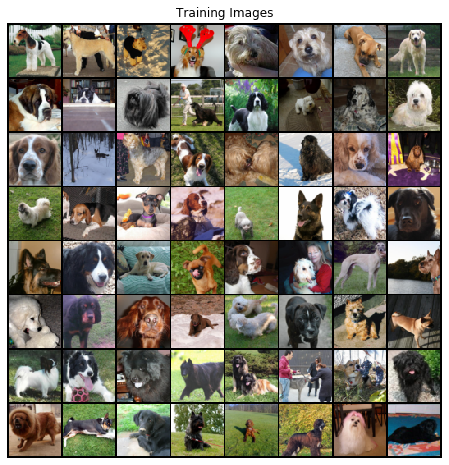

In [25]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=1)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [26]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [27]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [28]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [29]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [30]:
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [31]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [32]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...


/opt/conda/conda-bld/pytorch_1587428266983/work/aten/src/ATen/native/TensorFactories.cpp:361: UserWarning: Deprecation warning: In a future PyTorch release torch.full will no longer return tensors of floating dtype by default. Instead, a bool fill_value will return a tensor of torch.bool dtype, and an integral fill_value will return a tensor of torch.long dtype. Set the optional `dtype` or `out` arguments to suppress this warning.


[0/5][0/161]	Loss_D: 2.0153	Loss_G: 6.2374	D(x): 0.6260	D(G(z)): 0.7055 / 0.0031
[0/5][50/161]	Loss_D: 0.8737	Loss_G: 28.1189	D(x): 0.6085	D(G(z)): 0.0000 / 0.0000
[0/5][100/161]	Loss_D: 0.7768	Loss_G: 17.2250	D(x): 0.9375	D(G(z)): 0.4668 / 0.0000
[0/5][150/161]	Loss_D: 0.1832	Loss_G: 5.7126	D(x): 0.9225	D(G(z)): 0.0832 / 0.0071
[1/5][0/161]	Loss_D: 0.2080	Loss_G: 3.1704	D(x): 0.8615	D(G(z)): 0.0197 / 0.0664
[1/5][50/161]	Loss_D: 0.6689	Loss_G: 3.2499	D(x): 0.7072	D(G(z)): 0.1931 / 0.0576
[1/5][100/161]	Loss_D: 0.2189	Loss_G: 4.4528	D(x): 0.9058	D(G(z)): 0.1038 / 0.0142
[1/5][150/161]	Loss_D: 0.1807	Loss_G: 6.1727	D(x): 0.9232	D(G(z)): 0.0652 / 0.0030
[2/5][0/161]	Loss_D: 0.4497	Loss_G: 8.4107	D(x): 0.7486	D(G(z)): 0.0048 / 0.0006
[2/5][50/161]	Loss_D: 0.3600	Loss_G: 4.7984	D(x): 0.9168	D(G(z)): 0.2138 / 0.0116
[2/5][100/161]	Loss_D: 1.0243	Loss_G: 3.8005	D(x): 0.7854	D(G(z)): 0.4125 / 0.0351
[2/5][150/161]	Loss_D: 0.9128	Loss_G: 7.4773	D(x): 0.9374	D(G(z)): 0.5160 / 0.0010
[3/5][0/161

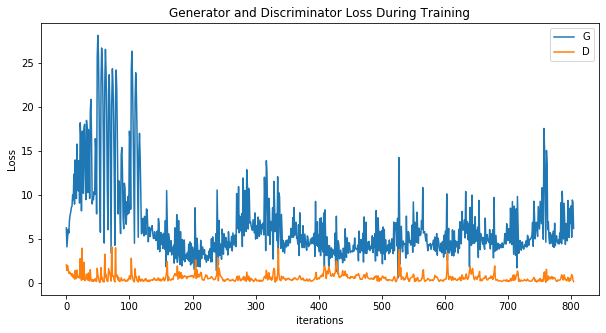

In [33]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

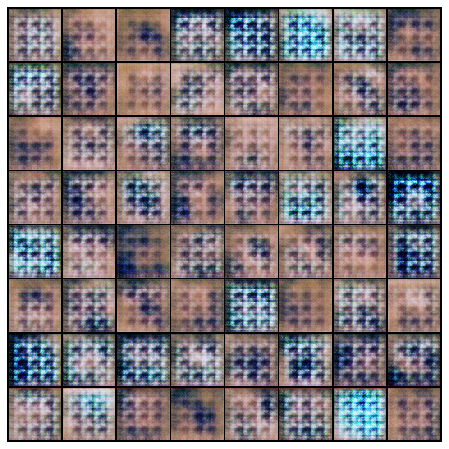

In [34]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

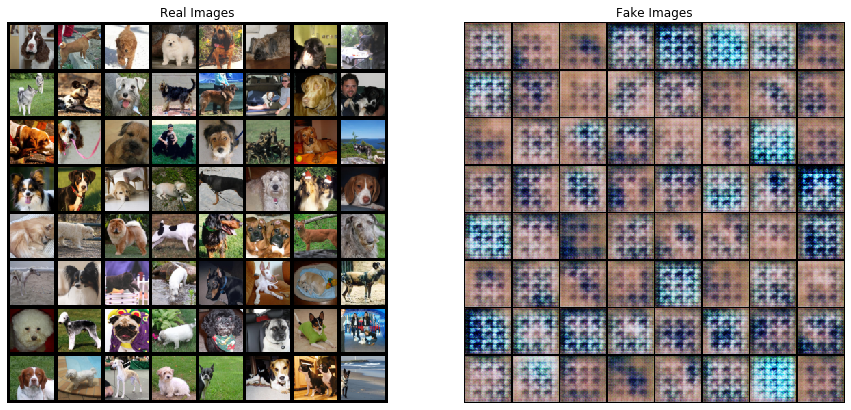

In [35]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [15]:
# import tarfile
# tar = tarfile.open("images.tar","r")
# tar.extractall('/home/pinkmonkey/Documents/Dogs_Breeds')

In [16]:
# tarl = tarfile.open("lists.tar","r")
# tarl.extractall('/home/pinkmonkey/Documents/Dogs_Breeds')

In [224]:
l = open("file_list.mat", "r")

In [226]:
import io
with open('file_list.mat', 'rb') as f2:
    mat = f2.read()
    #mat = pickle.load(f2, encoding="latin-1")
    print(mat)
#     wrapper = io.TextIOWrapper(f2, encoding='utf-8', write_through=True)
#     print(wrapper.read())
#     f2.close()

b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct  9 08:29:09 2011                                                \x00\x01IM\x0f\x00\x00\x00\x98\xb3\x01\x00x\x9c\xb4\x98\xcfJ\x031\x10\xc6WP\xd1K\xf1\r<\xb5\x9e\xd4\xcc\x9f\xcc$g_\xc0\xa37\x11\xfc\xd3J\x11A}b_\xc4\xd4\xae"=m\x06\xbf\xa5\xa1\xec\xb2\xf91|\x99\xf9&\xd9\xd90\x0c7\x9f\xa7\xc3a\xfb?jco\xd8^\x07\xe3\xfd\xfd\xf5\xf6\xd9f\x1c\xb7\xf1\xb8Z?\xdc\xaeWo\xef\xe3{\xb3\xcd\xfc6~\xe6\xef\xef\xcc\xdf\xcc;\xfb\xc3=\x19\xef_\x12\xa7\x92\x8d\xd3\xf9\xd5r\xb5\xfc\xb8k\xbf\xcb\xdfg\xb7\x94\x92\xeb\xc5\xf3\xeb\x13\x8cOBP\xbe\xf1t\xfeb\x87\xbf\x98\xc0w\xf9\xc6\xc3\xe2\xafnH}\x884A\xf9,\x05\xcb\xcfX\xbe\x88C\xf9\xea\xd3\xf9\x81\xfc\xa4\xcc\xd0\xfc$\xab\xd8\xfc,\x84]\xdf\xaa\xd3\xf9\x01\xfd9e\xa8\xfe\xdc\x1c\x14\xa9\x0f\x8bL\xf7\xff\x88>\xd2\xa1O\x84\xef\x84\xd5\xdf;\xf23\x12\x7f-\xd0\xf8\x852\xb4?\nc\xf5\x17)\x02\x8d_\r\x1b\x7f5\xe8\xfeJyl\x00(\xbe\xd2t\xfd#\xfcL\xd3\xfbK`}5c\xfdGkG\xff\r\xf0s\x02\xf3s\x87\xffD\xf8V\xa1|#\xc7\xf29A\x

In [17]:
img_dir = "/home/pinkmonkey/Documents/Dogs_Breeds/Images"

In [33]:
cd "/home/pinkmonkey/Documents/Dogs_Breeds/Images/n02085620-Chihuahua"

/home/pinkmonkey/Documents/Dogs_Breeds/Images/n02085620-Chihuahua


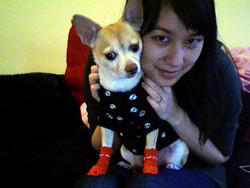

In [34]:
from PIL import Image
im = Image.open("n02085620_7.jpg")
im

In [52]:
from torchvision.transforms import ToTensor, ToPILImage
import numpy as np
tim = ToTensor()(im)
tim.shape

torch.Size([3, 188, 250])

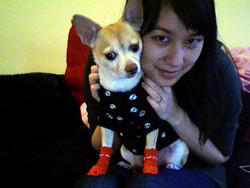

In [36]:
ToPILImage()(tim)

In [20]:
f = open('dogs', "rb")

In [21]:
import pickle

X = pickle.load(f, encoding="latin-1")

In [22]:
data, labels = X

In [23]:
data.shape

(20580, 128, 128, 3)

In [27]:
labels.shape

(20580, 120)

In [28]:
type(data)

numpy.ndarray

In [57]:
x_train, x_valid, y_train, y_valid = train_test_split(data, labels, test_size=0.20, random_state=123)

In [61]:
x_train[0].shape

(128, 128, 3)

In [63]:
x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

In [156]:
x_train.shape

torch.Size([16464, 128, 128, 3])

In [163]:
a = x_train[0].view(16384, 3)
a = torch.transpose(a, 0, 1)
a = a.view(3, 128, 128)
a.shape

torch.Size([3, 128, 128])

In [ ]:
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

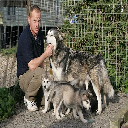

In [164]:
ToPILImage()(a)

In [202]:
x = torch.randn(2, 4, 3)
x

tensor([[[-0.3886,  1.3131,  0.0269],
         [ 0.0718,  1.4002, -0.4171],
         [ 0.4941,  0.3740, -1.4999],
         [-1.0730,  0.6493,  0.0508]],

        [[-0.3264, -0.9943,  1.5658],
         [ 1.7199, -0.8775,  0.5089],
         [ 1.2252, -0.7383,  1.0815],
         [ 0.5273,  0.4641, -0.6556]]])

In [219]:
#x = x.view(3, 4, 2)
xx = torch.transpose(x, 1, 2)
xx
#x.shape

tensor([[[-0.3886,  0.0718,  0.4941, -1.0730],
         [ 1.3131,  1.4002,  0.3740,  0.6493],
         [ 0.0269, -0.4171, -1.4999,  0.0508]],

        [[-0.3264,  1.7199,  1.2252,  0.5273],
         [-0.9943, -0.8775, -0.7383,  0.4641],
         [ 1.5658,  0.5089,  1.0815, -0.6556]]])

In [220]:
xx.shape

torch.Size([2, 3, 4])

In [192]:
a = data[11]
a = ToTensor()(a)

In [193]:
a

tensor([[[0.3216, 0.2941, 0.2392,  ..., 0.3451, 0.3725, 0.3686],
         [0.2941, 0.2902, 0.2392,  ..., 0.3569, 0.3843, 0.3725],
         [0.2980, 0.2902, 0.2157,  ..., 0.3137, 0.3333, 0.3333],
         ...,
         [0.3686, 0.3725, 0.3804,  ..., 0.2235, 0.2706, 0.3137],
         [0.4157, 0.3647, 0.3529,  ..., 0.2196, 0.2392, 0.2431],
         [0.2824, 0.3725, 0.3725,  ..., 0.1961, 0.2078, 0.2471]],

        [[0.5098, 0.5137, 0.4706,  ..., 0.5216, 0.5490, 0.5451],
         [0.4824, 0.5098, 0.4706,  ..., 0.5333, 0.5608, 0.5490],
         [0.4863, 0.5098, 0.4471,  ..., 0.4902, 0.5098, 0.5098],
         ...,
         [0.4431, 0.4392, 0.4353,  ..., 0.3725, 0.4196, 0.4627],
         [0.5020, 0.4392, 0.4196,  ..., 0.3686, 0.3882, 0.3922],
         [0.3686, 0.4588, 0.4392,  ..., 0.3529, 0.3647, 0.4000]],

        [[0.2667, 0.2745, 0.2588,  ..., 0.3922, 0.4196, 0.4157],
         [0.2392, 0.2706, 0.2588,  ..., 0.4039, 0.4314, 0.4196],
         [0.2431, 0.2706, 0.2353,  ..., 0.3608, 0.3804, 0.

In [198]:
a = torch.transpose(x_train[0], -3, 2)
a = torch.transpose(a, -2, 2)

In [199]:
a

tensor([[[0.4314, 0.2980, 0.2745,  ..., 0.1098, 0.6353, 0.1137],
         [0.2314, 0.2549, 0.2627,  ..., 0.3216, 0.5569, 0.2196],
         [0.3333, 0.2549, 0.1922,  ..., 0.3255, 0.3961, 0.2902],
         ...,
         [0.4157, 0.3020, 0.3647,  ..., 0.5137, 0.5333, 0.5176],
         [0.1647, 0.4275, 0.2824,  ..., 0.4431, 0.4314, 0.4902],
         [0.2235, 0.3059, 0.4980,  ..., 0.4196, 0.4039, 0.3765]],

        [[0.4392, 0.3059, 0.2824,  ..., 0.1725, 0.6824, 0.1137],
         [0.2392, 0.2627, 0.2706,  ..., 0.3725, 0.5961, 0.2392],
         [0.3412, 0.2627, 0.2000,  ..., 0.3569, 0.4118, 0.3412],
         ...,
         [0.4118, 0.3020, 0.3490,  ..., 0.4510, 0.4745, 0.4314],
         [0.1608, 0.4275, 0.2667,  ..., 0.3725, 0.3647, 0.4000],
         [0.2196, 0.3059, 0.4824,  ..., 0.3529, 0.3451, 0.3059]],

        [[0.4275, 0.2941, 0.2706,  ..., 0.0000, 0.5961, 0.0118],
         [0.2275, 0.2510, 0.2588,  ..., 0.2000, 0.5020, 0.1490],
         [0.3294, 0.2510, 0.1882,  ..., 0.2039, 0.3216, 0.

In [200]:
a.shape

torch.Size([3, 128, 128])

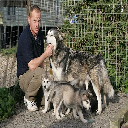

In [201]:
ToPILImage()(a)

In [146]:
for i in data:
    ((x_train, y_train), (x_valid, y_valid), _) = data[]

SyntaxError: invalid syntax (<ipython-input-146-f68614dd8d7a>, line 2)

Scikit learn split
Poprobui tolko odnu papku s photo raspakovat’
Matfile S label raspakui

In [49]:
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
import numpy as np
import random

import tarfile
import io
import os
import pandas as pd

from torch.utils.data import Dataset
import torch

class YourDataset(Dataset):
    def __init__(self, txt_path='filelist.txt', img_dir='data.tar', transform=None):
        """
        Initialize data set as a list of IDs corresponding to each item of data set

        :param img_dir: path to image files as a uncompressed tar archive
        :param txt_path: a text file containing names of all of images line by line
        :param transform: apply some transforms like cropping, rotating, etc on input image
        """

        df = pd.read_csv(txt_path, sep=' ', index_col=0)
        self.img_names = df.index.values
        self.txt_path = txt_path
        self.img_dir = img_dir
        self.transform = transform
        self.to_tensor = ToTensor()
        self.to_pil = ToPILImage()
        self.tf = tarfile.open(self.img_dir)

    def get_image_from_tar(self, name):
        """
        Gets a image by a name gathered from file list csv file

        :param name: name of targeted image
        :return: a PIL image
        """
        image = self.tf.extractfile(name)
        image = image.read()
        image = Image.open(io.BytesIO(image))
        return image

    def __len__(self):
        """
        Return the length of data set using list of IDs

        :return: number of samples in data set
        """
        return len(self.img_names)

    def __getitem__(self, index):
        """
        Generate one item of data set.

        :param index: index of item in IDs list

        :return: a sample of data as a dict
        """

        if index == (self.__len__() - 1) :  # close tarfile opened in __init__
            self.tf.close()

        
        image = self.get_image_from_tar(self.img_names[index])
       
        if self.transform is not None:
            image = self.transform(image)

        sample = {'X': image}

        return sample

In [ ]:
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
import numpy as np
import random

import tarfile
import io
import os
import pandas as pd

from torch.utils.data import Dataset
import torch

class YourDataset(Dataset):
    def __init__(self, txt_path='filelist.txt', img_dir='data.tar', transform=None):
        """
        Initialize data set as a list of IDs corresponding to each item of data set

        :param img_dir: path to image files as a uncompressed tar archive
        :param txt_path: a text file containing names of all of images line by line
        :param transform: apply some transforms like cropping, rotating, etc on input image
        """

        df = pd.read_csv(txt_path, sep=' ', index_col=0)
        self.img_names = df.index.values
        self.txt_path = txt_path
        self.img_dir = img_dir
        self.transform = transform
        self.to_tensor = ToTensor()
        self.to_pil = ToPILImage()
        self.tf = tarfile.open(self.img_dir)

    def get_image_from_tar(self, name):
        """
        Gets a image by a name gathered from file list csv file

        :param name: name of targeted image
        :return: a PIL image
        """
        image = self.tf.extractfile(name)
        image = image.read()
        image = Image.open(io.BytesIO(image))
        return image

    def __len__(self):
        """
        Return the length of data set using list of IDs

        :return: number of samples in data set
        """
        return len(self.img_names)

    def __getitem__(self, index):
        """
        Generate one item of data set.

        :param index: index of item in IDs list

        :return: a sample of data as a dict
        """

        if index == (self.__len__() - 1) :  # close tarfile opened in __init__
            self.tf.close()

        
        image = self.get_image_from_tar(self.img_names[index])
       
        if self.transform is not None:
            image = self.transform(image)

        sample = {'X': image}

        return sample